In [1]:
%load_ext pretty_jupyter

In [2]:
import tomlkit
import scanpy as sc
import anndata as ad
from anndata import AnnData
from scipy.stats import median_abs_deviation
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import patchworklib as pw
import pandas as pd
from typing import List, Dict, Callable
import seaborn.objects as so

<Figure size 100x100 with 0 Axes>

# Configs

## Utility Functions

In [3]:
def get_sample_name(file_path: str, black_list: list[str], n = 3):
    from os import path
    """"Function to return probable sample name from a path, it recurselvy goes through the path and returns the first element not in the black list."""
    if n == 0:
        return ""

    tmp = path.basename(file_path)
    _d = path.dirname(file_path)

    if tmp not in black_list:
        return tmp
    else:
        res = get_sample_name(_d, black_list, n-1)
    return res


def is_outlier(adata: AnnData, metric: str, nmads: int):
    
    M = adata.obs[metric]
    outlier = (M < np.median(M) - nmads * median_abs_deviation(M)) | (
        np.median(M) + nmads * median_abs_deviation(M) < M
    )
    return outlier


def read_parsebio(data_path: str):
    """Reads ParseBio

    Args:
        data_path (str): _description_

    Returns:
        _type_: _description_
    """    

    adata = sc.read_mtx(data_path + 'count_matrix.mtx')

    # reading in gene and cell data
    gene_data = pd.read_csv(data_path + 'all_genes.csv')
    cell_meta = pd.read_csv(data_path + 'cell_metadata.csv')

    # find genes with nan values and filter
    gene_data = gene_data[gene_data.gene_name.notnull()]
    notNa = gene_data.index
    notNa = notNa.to_list()

    # remove genes with nan values and assign gene names
    adata = adata[:,notNa]
    adata.var = gene_data
    adata.var.set_index('gene_name', inplace=True)
    adata.var.index.name = None
    adata.var_names_make_unique()

    # add cell meta data to anndata object
    adata.obs = cell_meta
    adata.obs.set_index('bc_wells', inplace=True)
    adata.obs.index.name = None
    adata.obs_names_make_unique()

    return adata



## Technology components

In [4]:

inputs: Dict[str, List|Callable] = {
          "10x":{
                 "files": ['features.tsv.gz', 'barcodes.tsv.gz', 'matrix.mtx.gz'],
                 "black_list": ["filtered_feature_bc_matrix", "raw_feature_bc_matrix"],
                 "raw_name": "raw_feature_bc_matrix",
                 "function": sc.read_10x_mtx
                 },

          "ParseBio":{
                    "files": ["all_genes.csv", "cell_metadata.csv", "count_matrix.mtx"],
                    "black_list": ["DGE_filtered", "DGE_unfiltered"],
                    "function": read_parsebio
                    }
          }


qc_features_fac: Dict[str, List[str]] = {"human": {
                         "mito": ["MT-"],
                         "ribo": ["RBS", "RPL"],
                         "hb": ["^HB[^(P)]"]
                         },
               "mouse": {
                        "mito": ["mt"],
                        "ribo": ["Rps", "Rps"],
                        "hb": ["^Hb[^(p)]"] # Validate this later
               }
                         }



## Pipeline parameters

In [5]:
with open("./config.toml", "r") as f:
    config = tomlkit.parse(f.read())
config

{'basic': {'ROOT_PATH': '/root/of/project', 'DIR_SAMPLES': '../test', 'TECHNOLOGY': '10x', 'ORGANISM': 'human', 'auto_find': True, 'samples': {}}, 'QC': {'CONCAT_SAMPLES': True, 'NMADS': 5, 'NMADS_MITO': 3, 'CORRECT_AMBIENT_RNA': True, 'FILTER_DOUBLETS': True, 'CELL_CYCLE_SCORE': False, 'REGRESS': False, 'VARS_TO_REGRESS': []}, 'Normalization': {}}

In [6]:
DIR_samples = config["basic"]["DIR_SAMPLES"] 
TECHNOLOGY: str = config["basic"]["TECHNOLOGY"]
ORGANISM: str = config["basic"]["ORGANISM"]
AUTODISCOVER: bool = config["basic"]["auto_find"]

CONCAT_SAMPLES: bool = config["QC"]["CONCAT_SAMPLES"]
NMADS: int = config["QC"]["NMADS"]
NMADS_MITO: int = config["QC"]["NMADS_MITO"]
CORRECT_AMBIENT_RNA = config["QC"]["CORRECT_AMBIENT_RNA"]
FILTER_DOUBLETS: bool = config["QC"]["FILTER_DOUBLETS"]
REGRESS: bool = config["QC"]["REGRESS"]
CELL_CYCLE_SCORE: bool = config["QC"]["FILTER_DOUBLETS"]
VARS_TO_REGRESS: List[str]|None = config["QC"]["VARS_TO_REGRESS"] 

sample_components = inputs[TECHNOLOGY]["files"]
black_list = inputs[TECHNOLOGY]["black_list"]
read_function = inputs[TECHNOLOGY]["function"]
raw_name = inputs[TECHNOLOGY]["raw_name"]


## Over-ride Pipeline parameters
**in the following cell, override the default pipeline parameters if needed**

# Diagnosic pipeline

## Reading files

In [7]:
from os import walk, path

samples = {}
if AUTODISCOVER:
    files = walk(DIR_samples)
    for root, dir, files in files:
        if len(set(sample_components).difference(set(files))) == 0 and path.basename(root) != raw_name:
            samples[get_sample_name(root, black_list, 4)] = root
else:
    samples = config["basic"]["samples"]
    if len(samples) > 0:
        pass
    else:
        raise RuntimeError("No samples paths were provided, provide sample paths as a dictionary in 'config.toml'")


In [8]:
adatas = {}
raw_h5 = {}
for sample_id, filename in samples.items():
    sample_adata = read_function(filename)
    sample_adata.var_names_make_unique()
    adatas[sample_id] = sample_adata

if TECHNOLOGY == "10x":
    for sample_id, filename in samples.items():
        adata_raw = sc.read_10x_h5(path.join(path.dirname(filename), "raw_feature_bc_matrix.h5"))
        adata_raw.var_names_make_unique()
        raw_h5[sample_id] = adata_raw


if CONCAT_SAMPLES:
    adata = ad.concat(adatas, label="sample", join="outer", merge="same")
    adata.obs_names_make_unique()
    del samples

if CONCAT_SAMPLES and TECHNOLOGY == "10x":
    adata_raw = ad.concat(raw_h5, label="sample", join="outer", merge="same")
    adata_raw.obs_names_make_unique()
    del raw_h5


**TODO:**
- [ ] Handle also multple samples at once
- [ ] Make the Oulier function parameterized on sample

## Adding quality metrics

In [9]:
mt_features = qc_features_fac[ORGANISM]["mito"]
rb_features = qc_features_fac[ORGANISM]["ribo"]
hb_features = qc_features_fac[ORGANISM]["hb"]


# mitochondrial genes, "MT-" for human, "Mt-" for mouse
adata.var["mt"] = adata.var_names.str.startswith(tuple(mt_features))
# ribosomal genes
adata.var["ribo"] = adata.var_names.str.startswith(tuple(rb_features))
# hemoglobin genes
adata.var["hb"] = adata.var_names.str.contains(tuple(hb_features)[0]) #Only regex is accepted

sc.pp.calculate_qc_metrics(
    adata, qc_vars=["mt", "ribo", "hb"], percent_top=[20],  inplace=True, log1p=True
)



In [10]:
#TODO: Add additional Critera for filtering based on Absolute thresholds, can it be per sample?

adata.obs["outlier"] = (
    is_outlier(adata, "log1p_total_counts", NMADS)
    | is_outlier(adata, "log1p_n_genes_by_counts", NMADS)
    | is_outlier(adata, "pct_counts_in_top_20_genes", NMADS)
)

adata.obs["mt_outlier"] = is_outlier(adata, "pct_counts_mt", NMADS_MITO) 

## Ambient RNA correction

In [13]:

if CORRECT_AMBIENT_RNA:

    from os import system, remove, path
    import tempfile

    with tempfile.TemporaryDirectory(dir=".") as tmpdirname:
        # Define paths for temporary files
        sce_path = path.join(tmpdirname, "sce.h5ad")
        raw_path = path.join(tmpdirname, "raw.h5ad")
        decontx_path = path.join(tmpdirname, "decontX.h5ad")
        
        # Save adata and adata_raw to the temporary directory
        adata.write_h5ad(sce_path)
        adata_raw.write_h5ad(raw_path)
        
        # Execute R scripts with temporary file paths
        system(f"Rscript ./deconx.R -s {sce_path} -r {raw_path} -o {decontx_path}")

        # Read the result back from the temporary directory
        adata = sc.read_h5ad(decontx_path)



All specified packages are already installed.
Mon Jun  3 14:52:48 2024 ..  35074  cells in the background matrix were removed as they were found in  the filtered matrix.
--------------------------------------------------
Starting DecontX
--------------------------------------------------
Mon Jun  3 14:52:49 2024 .. Analyzing all cells
Mon Jun  3 14:52:50 2024 .... Generating UMAP and estimating cell types
Found more than one class "dist" in cache; using the first, from namespace 'spam'
Also defined by ‘BiocGenerics’
Found more than one class "dist" in cache; using the first, from namespace 'spam'
Also defined by ‘BiocGenerics’
Found more than one class "dist" in cache; using the first, from namespace 'spam'
Also defined by ‘BiocGenerics’
Mon Jun  3 14:53:37 2024 .... Estimating contamination
Mon Jun  3 14:53:46 2024 ...... Completed iteration: 10 | converge: 0.03771
Mon Jun  3 14:53:53 2024 ...... Completed iteration: 20 | converge: 0.02195
Mon Jun  3 14:54:00 2024 ...... Completed ite

In [16]:
adata

AnnData object with n_obs × n_vars = 35074 × 36601
    obs: 'sample', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'outlier', 'mt_outlier', 'decontX_contamination', 'decontX_clusters'
    var: 'gene_ids', 'feature_types', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: 'X_name', 'decontX'
    obsm: 'decontX_UMAP'
    layers: 'decontXcounts'

## Doublet Detection

In [44]:
#TODO: Check real-life performance
#TODO: Check Interop with R to convert object to R & vice-versa 
if FILTER_DOUBLETS:
    sc.pp.scrublet(adata, batch_key="sample")

## Cell cycle Scoring

**Not reliable, do via interop later**

In [45]:
# Split into 2 lists
s_genes = [x.strip() for x in open('../Resources/s_genes.txt')]
g2m_genes = [x.strip() for x in open('../Resources/s_genes.txt')]

In [12]:
adata.layers["counts"] = adata.X.copy()
sc.pp.normalize_per_cell(adata)
sc.pp.log1p(adata)
sc.pp.scale(adata)

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


Randomly sampling 50000 droplets to calculate the ambient profile.
Working...: 100%|██████████| 3/3 [00:36<00:00, 12.07s/it]


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Epoch 3/228:   1%|          | 2/228 [01:14<2:19:04, 36.92s/it, v_num=1, train_loss_step=1.33e+4, train_loss_epoch=1.33e+4]

In [47]:
# Cell cycle scoring is not reliable and not similair to Seurat
sc.tl.score_genes_cell_cycle(adata, s_genes=s_genes, g2m_genes=g2m_genes)

## Quality Plots

### Basic QC plots & metrics

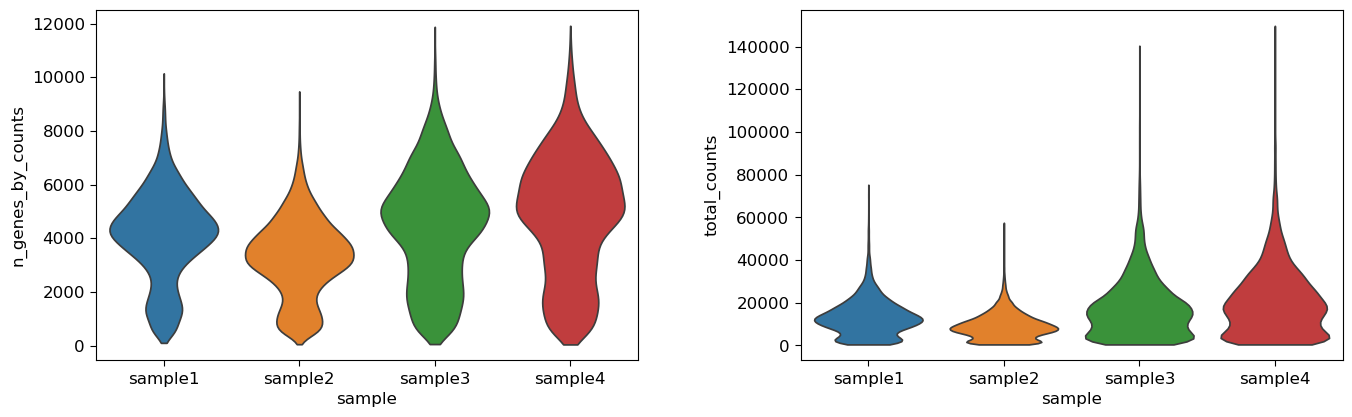

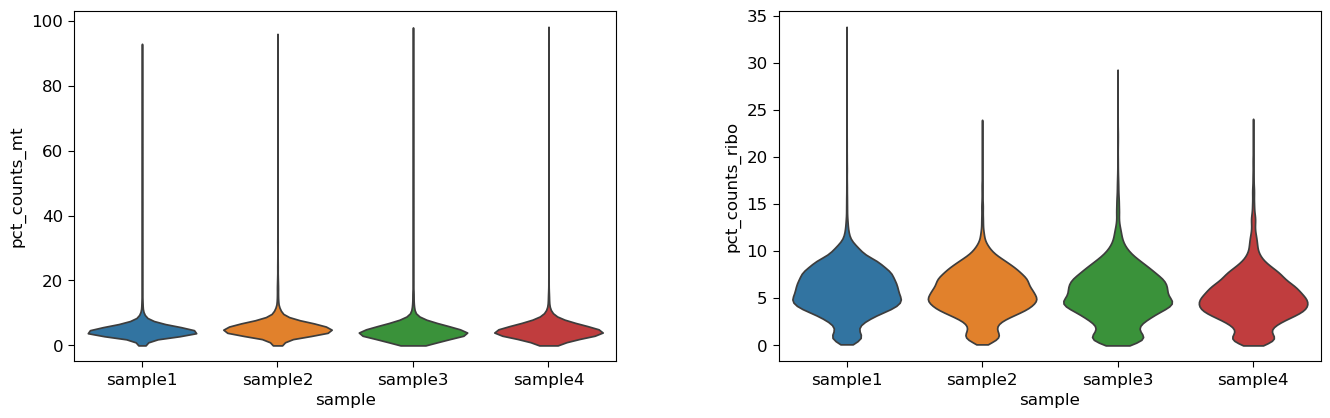

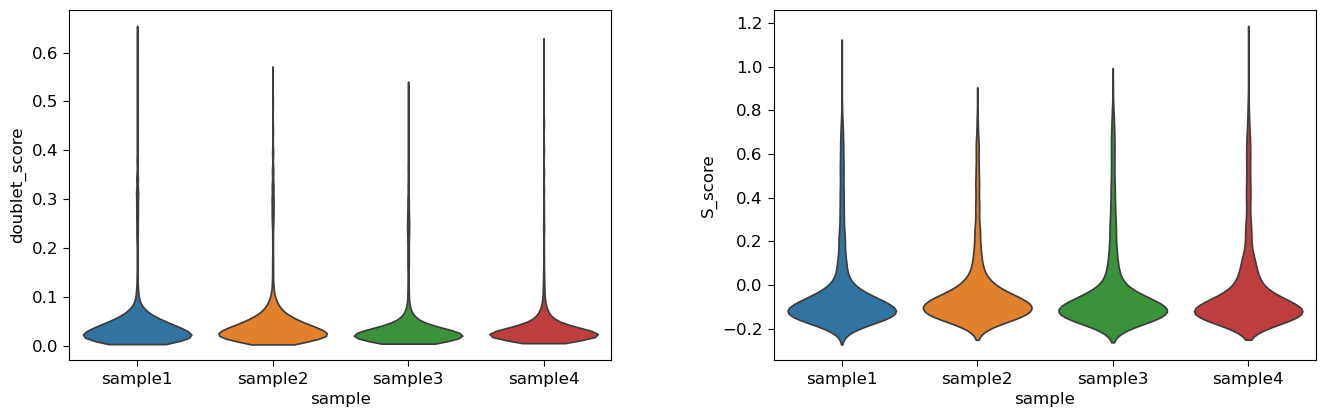

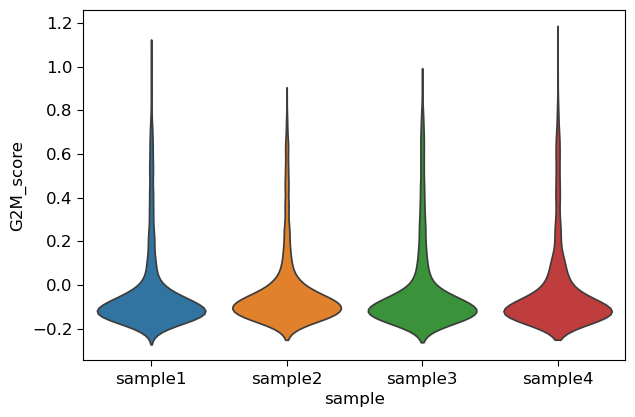

In [89]:
keys = ["n_genes_by_counts", "total_counts", "pct_counts_mt", "pct_counts_ribo", "doublet_score", "S_score", "G2M_score"]
chunks = [keys[i:i + 2] for i in range(0, len(keys), 2)]

for chunk in chunks:
    sc.pl.violin(
        adata,
        chunk,
        jitter=0.1,
        multi_panel=True,
        groupby="sample",
        stripplot=False
    )

In [108]:
df1 = adata.obs.groupby("sample")[["total_counts", "n_genes_by_counts", "pct_counts_mt", "pct_counts_ribo", "pct_counts_hb", "doublet_score"]].agg(["mean", "median"]).round(3)
df2 = adata.obs.groupby("sample")[["sample"]].agg(["size"])
pd.concat([df1, df2], axis =1)

total_counts          n_genes_by_counts         pct_counts_mt         \
                 mean   median              mean  median          mean median   
sample                                                                          
sample1  13508.561523  12549.0          4078.270  4238.0         4.811  4.394   
sample2   9307.657227   8527.0          3283.994  3361.0         5.623  5.048   
sample3  18033.693359  15636.5          4441.597  4633.5         4.610  4.024   
sample4  20888.236328  18396.0          4816.131  5045.0         5.018  4.314   

        pct_counts_ribo        pct_counts_hb        doublet_score         \
                   mean median          mean median          mean median   
sample                                                                     
sample1           5.922  5.839         0.013  0.005         0.046  0.029   
sample2           5.658  5.561         0.010  0.000         0.048  0.030   
sample3           5.475  5.318         0.035  0.006         0.041  0.024   
sample4           5.128  4.855         0.044  0.007         0.038  0.026   

        sample  
          size  
sample          
sample1   9197  
sample2  10290  
sample3   8222  
sample4   7365

### Histograms

In [136]:
ax1 = pw.Brick(figsize=(3,2))
ax2 = pw.Brick(figsize=(3,2))
ax3 = pw.Brick(figsize=(3,2))
ax4 = pw.Brick(figsize=(3,2))

sns.histplot(data=adata.obs, x="total_counts", hue="sample", bins=300, ax = ax1)
sns.histplot(data=adata.obs, x="n_genes_by_counts", hue="sample", bins=300, ax = ax2)
sns.histplot(data=adata.obs, x="pct_counts_ribo", hue="sample", bins=300, ax = ax3)
sns.histplot(data=adata.obs, x="pct_counts_mt", hue="sample", bins=300, ax = ax4)


for ax in [ax1, ax2, ax3, ax4]:
    ax.move_legend(new_loc='upper left', bbox_to_anchor=(1.05, 1.0))
    legend = ax.legend_
    for t in legend.get_texts():
        t.set_fontsize(8)

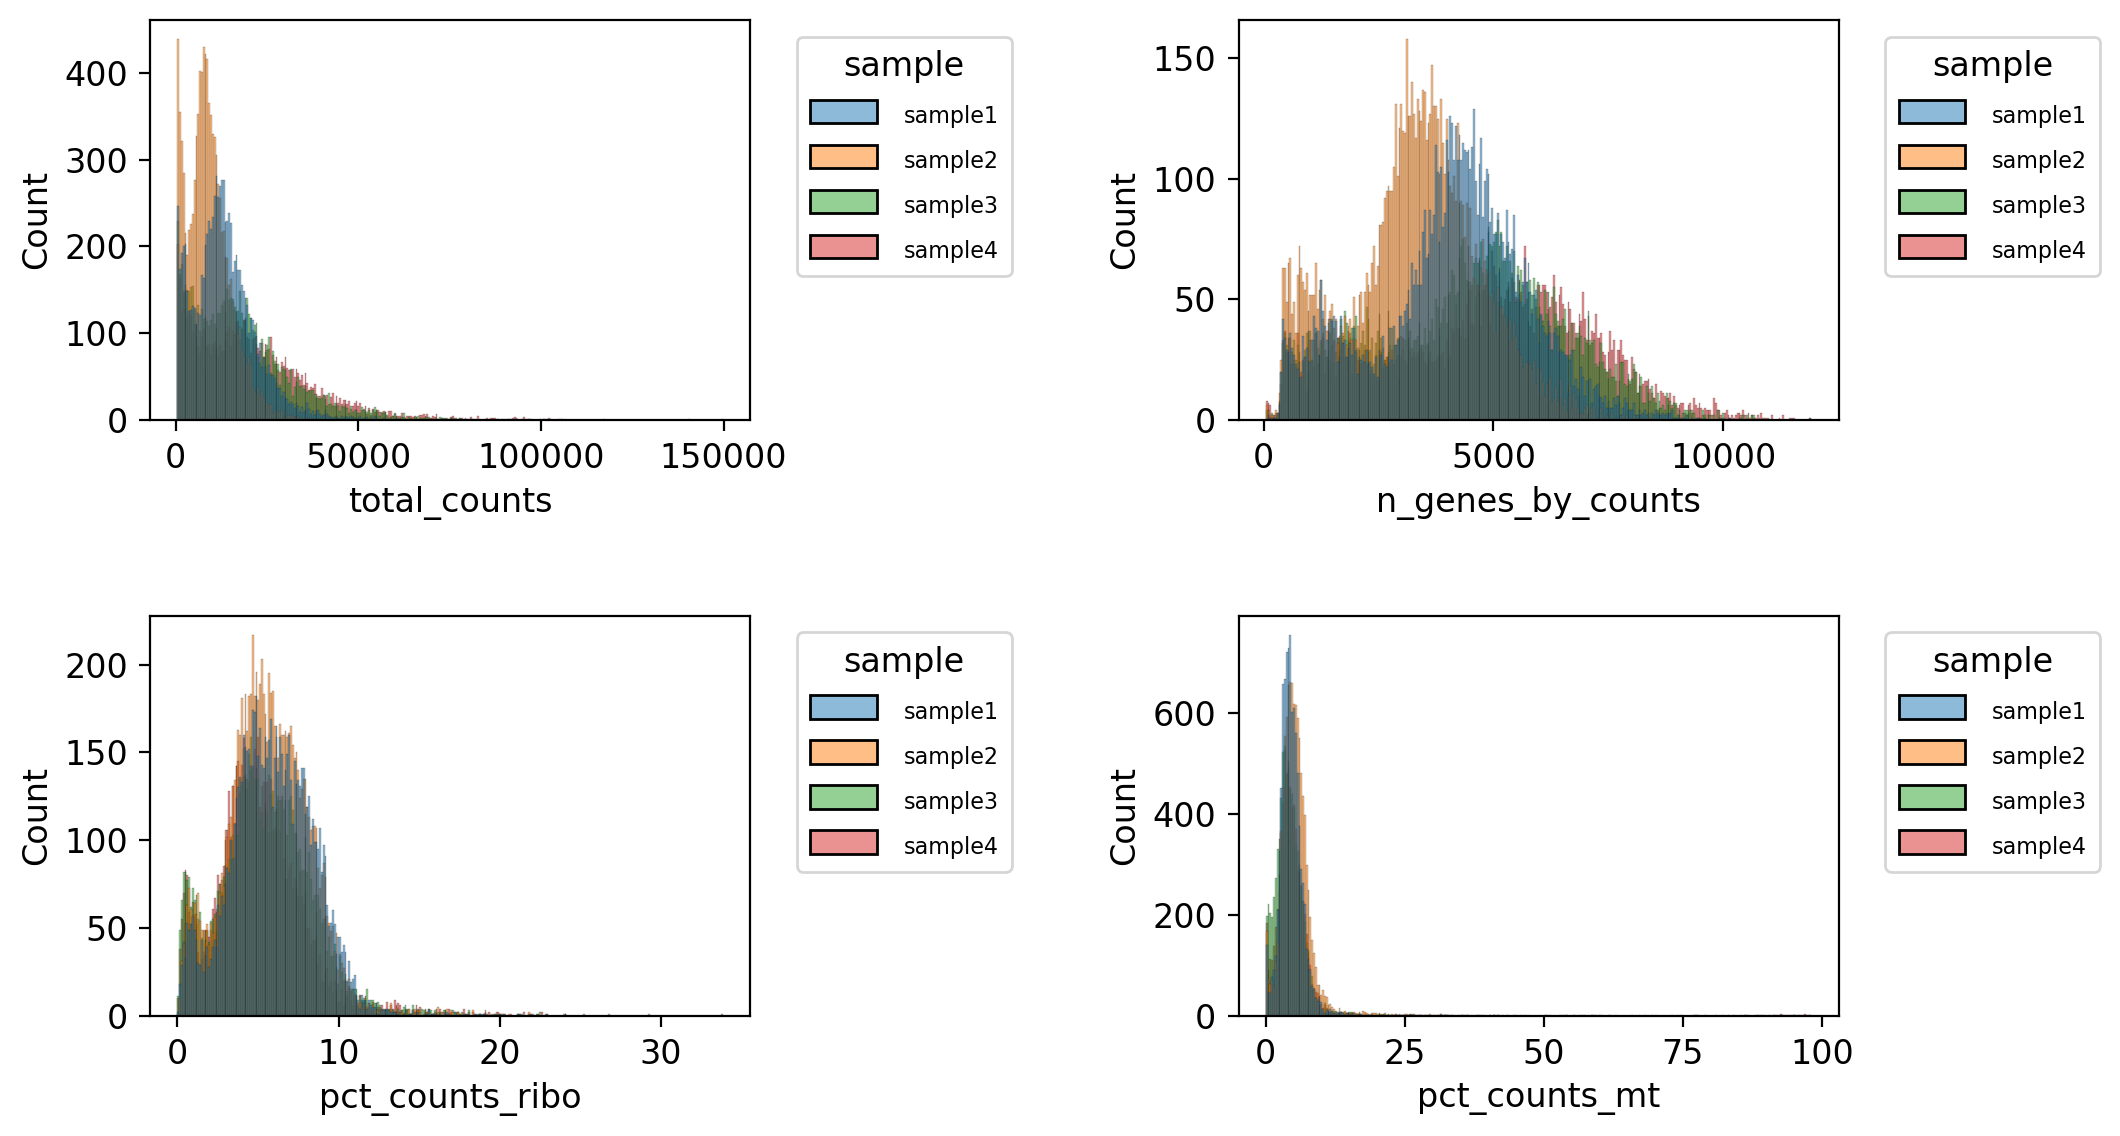

In [137]:
(ax1+ax2)/(ax3+ax4)

### Scatter plots of confounders

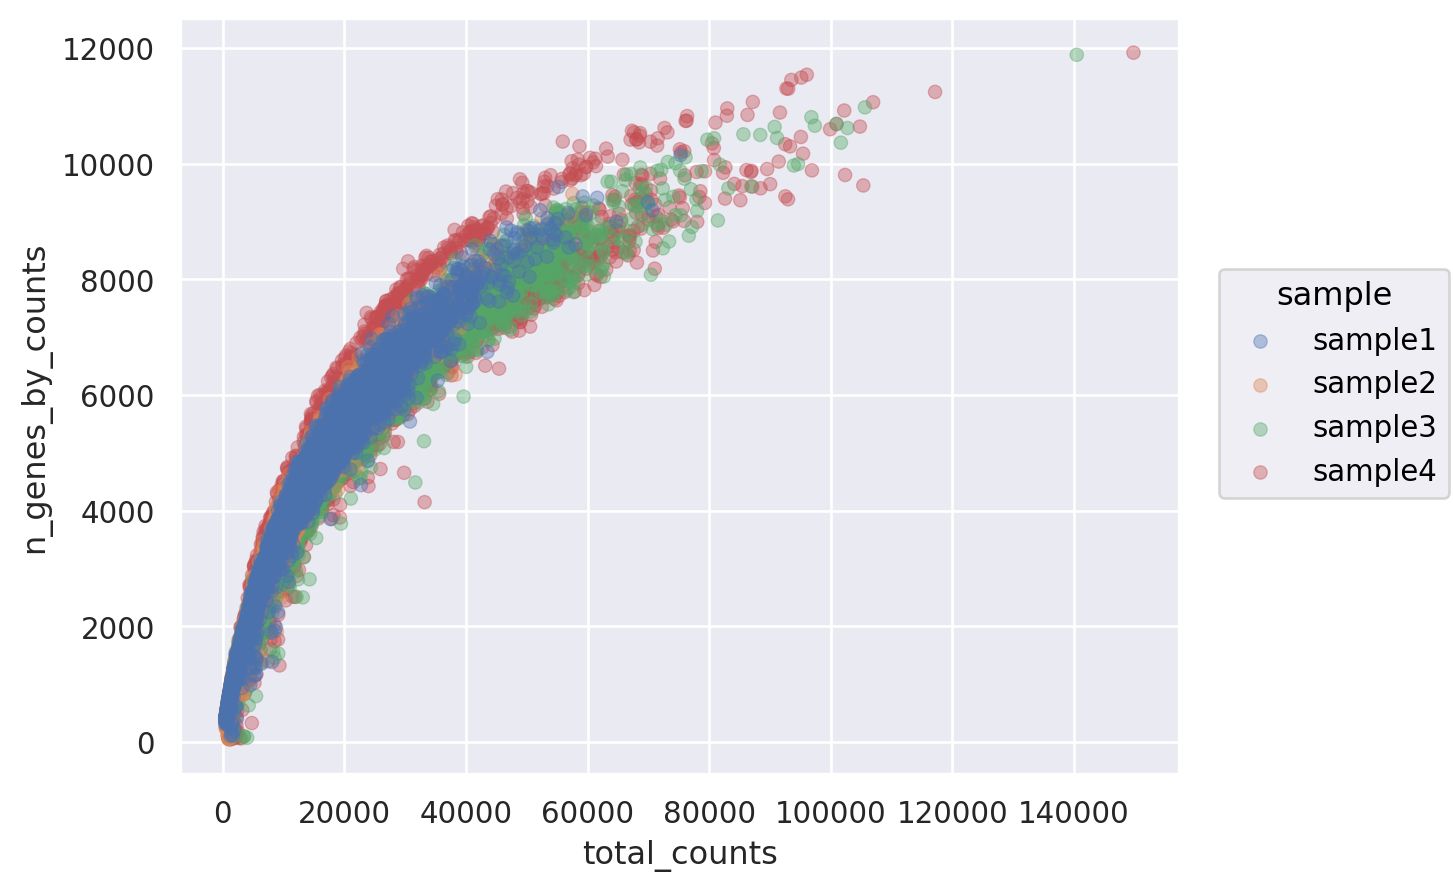

In [128]:

f2 = (
    so.Plot(adata.obs, x="total_counts", y="n_genes_by_counts", color = "sample")
    .add(so.Dot(pointsize=5, alpha=0.4))
)
f2

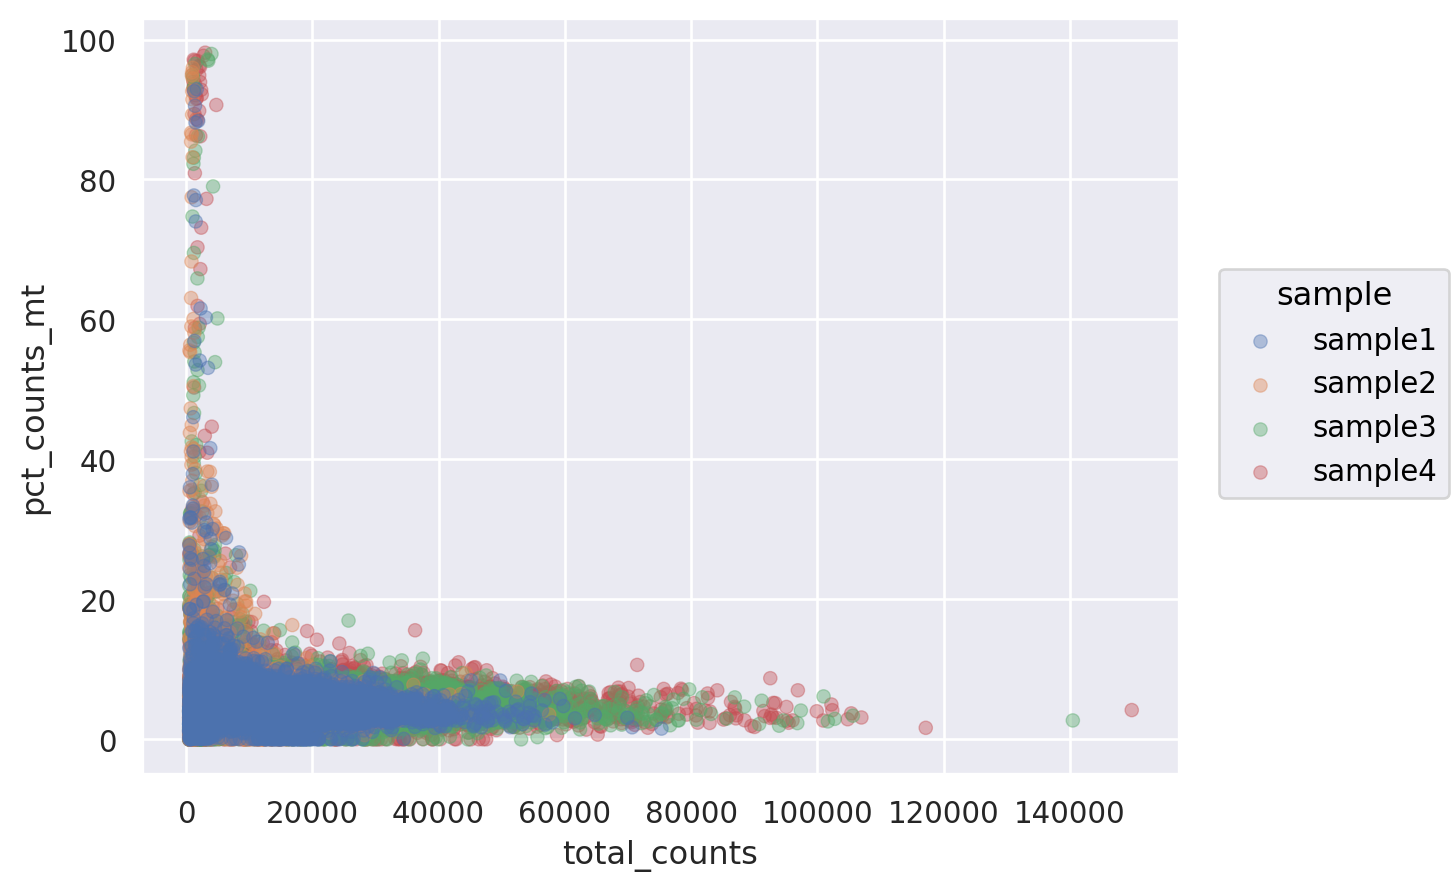

In [123]:
f1 = (
    so.Plot(adata.obs, x="total_counts", y="pct_counts_mt", color = "sample")
    .add(so.Dot(pointsize=5, alpha=0.4))
)
f1

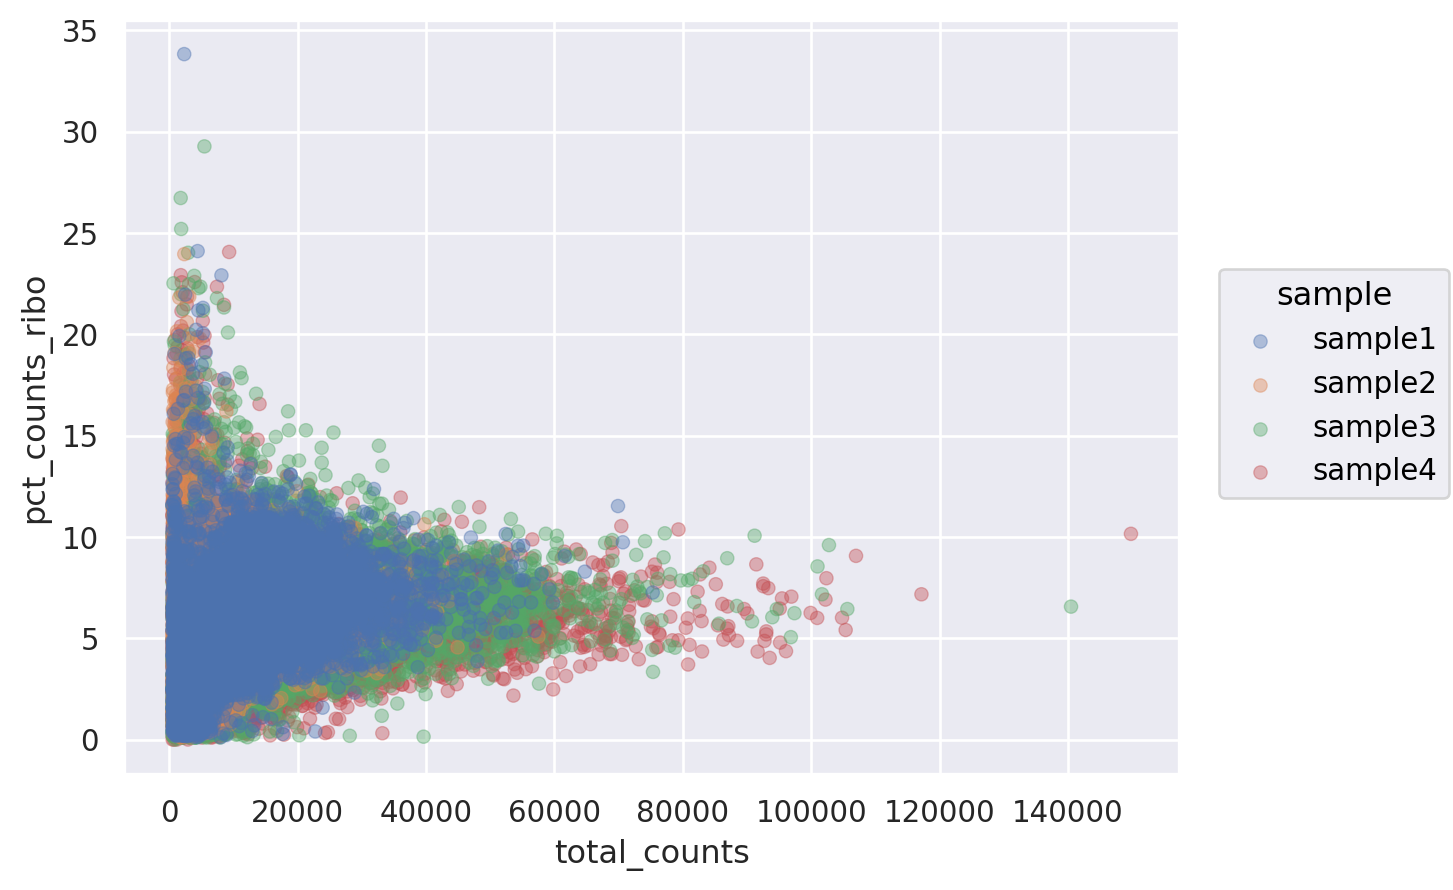

In [122]:

f2 = (
    so.Plot(adata.obs, x="total_counts", y="pct_counts_ribo", color = "sample")
    .add(so.Dot(pointsize=5, alpha=0.4))
)
f2

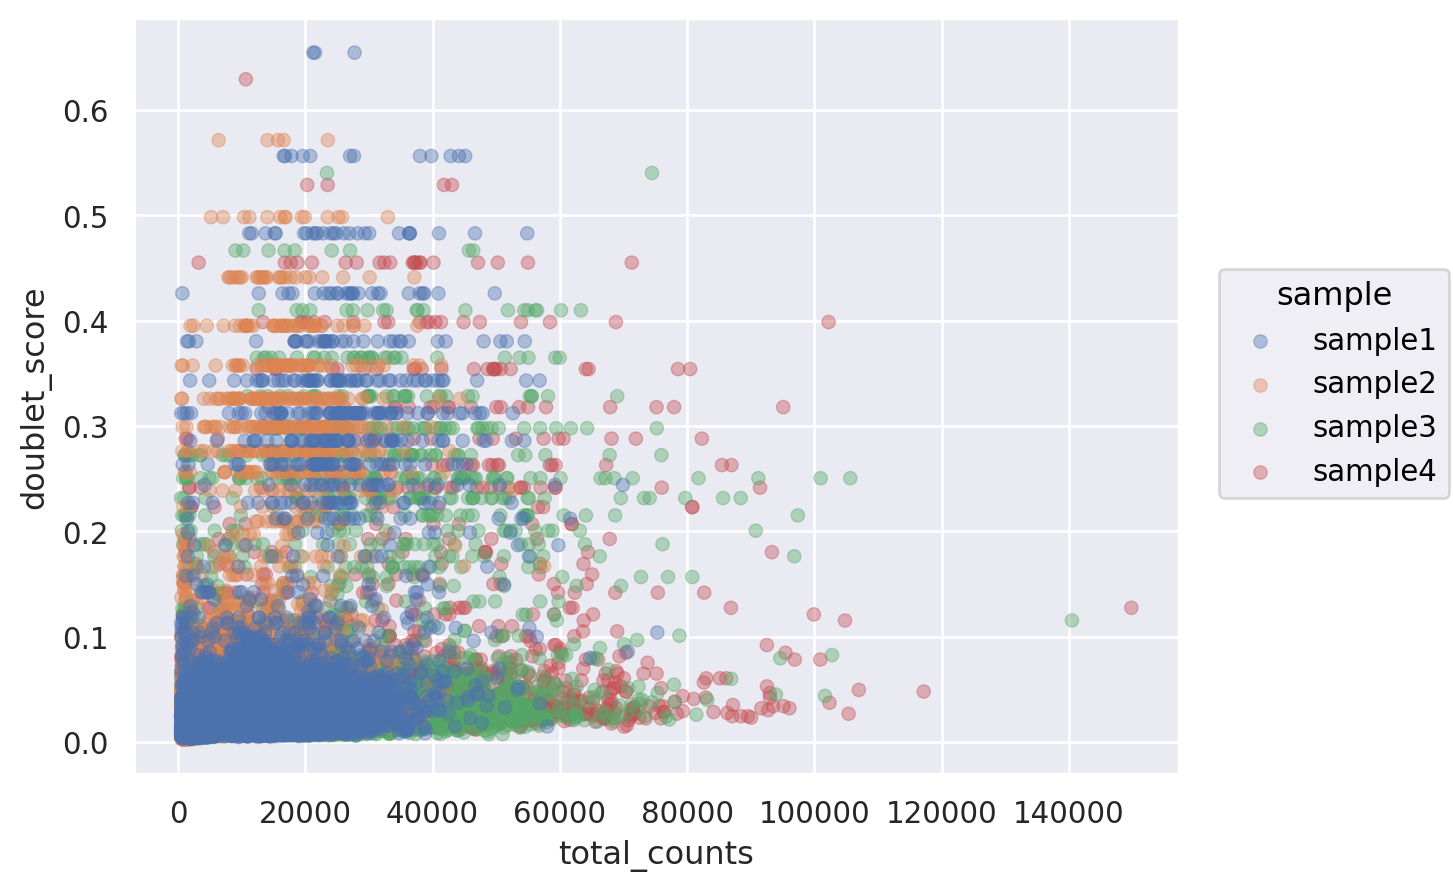

In [121]:
f2 = (
    so.Plot(adata.obs, x="total_counts", y="doublet_score", color = "sample")
    .add(so.Dot(pointsize=5, alpha=0.4))
)
f2

## Clustering prior to cell filtering

In [138]:
sc.pp.pca(adata, n_comps=20)
sc.pp.neighbors(adata)
sc.tl.leiden(adata, key_added="groups", flavor="igraph")
sc.tl.umap(adata)

[<Axes: title={'center': 'sample'}, xlabel='UMAP1', ylabel='UMAP2'>,
 <Axes: title={'center': 'total_counts'}, xlabel='UMAP1', ylabel='UMAP2'>,
 <Axes: title={'center': 'n_genes_by_counts'}, xlabel='UMAP1', ylabel='UMAP2'>,
 <Axes: title={'center': 'pct_counts_mt'}, xlabel='UMAP1', ylabel='UMAP2'>,
 <Axes: title={'center': 'predicted_doublet'}, xlabel='UMAP1', ylabel='UMAP2'>,
 <Axes: title={'center': 'phase'}, xlabel='UMAP1', ylabel='UMAP2'>]

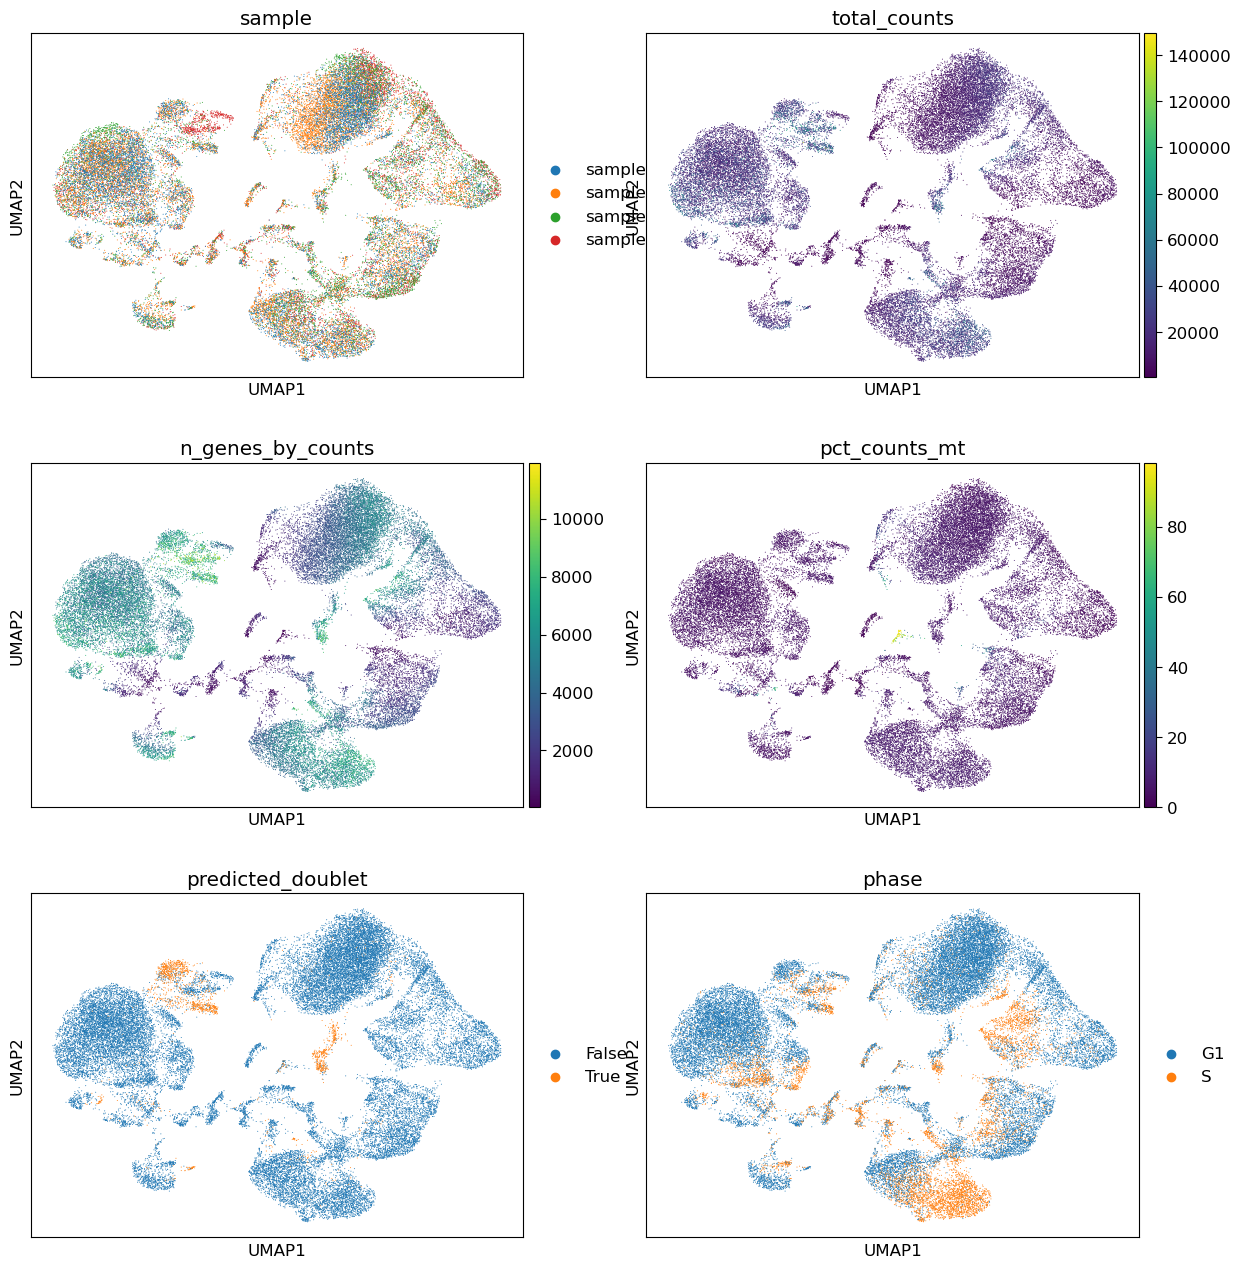

In [141]:
sc.pl.umap(adata, size= 2,color= ["sample", "total_counts", "n_genes_by_counts", "pct_counts_mt", "predicted_doublet", "phase"], show=False, ncols = 2)

# Filtering Pipeline

In [ ]:
manual_filters = {}

## Cell filtering based on outlier function

In [21]:
adata = adata[(~adata.obs.outlier) & (~adata.obs.mt_outlier)].copy()

In [ ]:
p1 = sc.pl.scatter(adata, "total_counts", "n_genes_by_counts", color="pct_counts_mt")

## Regression of Variables
- [ ] Add error handling if the vars to regress is empty or contain non-keys

In [22]:
if REGRESS:
    sc.pp.regress_out(adata, keys= VARS_TO_REGRESS)

## Clustering After Cell filtering 

In [ ]:
sc.pp.pca(adata, n_comps=20)
sc.pp.neighbors(adata)
sc.tl.leiden(adata, key_added="groups", flavor="igraph")
sc.tl.umap(adata)

In [ ]:
sc.pl.umap(adata, size= 2,color= ["sample", "total_counts", "n_genes_by_counts", "pct_counts_mt"], show=False, ncols = 2)

## Save Result

In [34]:
adata.write_h5ad("adata.h5ad")